<a href="https://colab.research.google.com/github/Rodisolomon/Rodisolomon/blob/main/ml_large_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## preprocess

In [1]:
import json
from google.colab import drive
from pprint import pprint
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import eig
from sklearn.linear_model import LogisticRegression
from keras.datasets import mnist
from scipy.special import softmax
from scipy.special import logsumexp

drive.mount('/content/drive', force_remount=True)
data = np.load("/content/drive/MyDrive/ml_large/MNIST_data.npy")
%matplotlib inline

Mounted at /content/drive


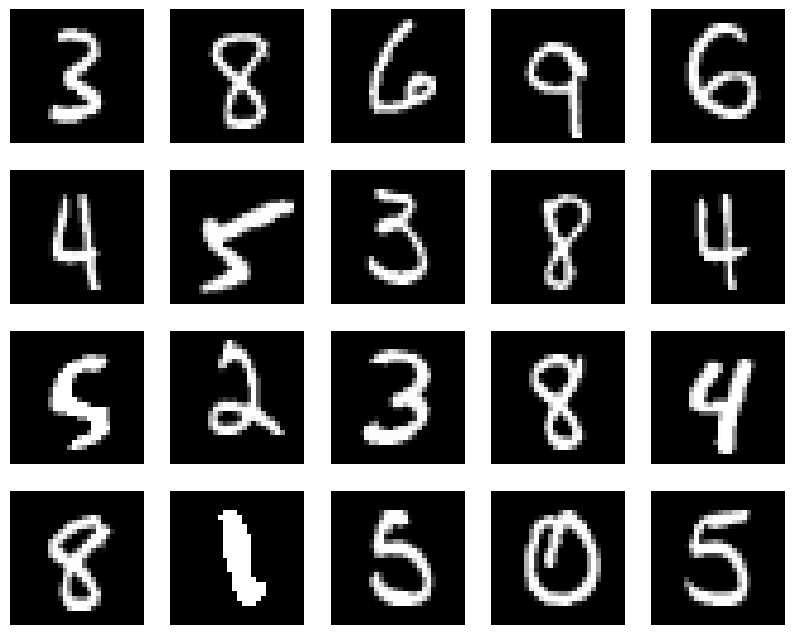

In [2]:
nrows = 4
ncols = 5
plt.figure(figsize=(ncols*2, nrows*2))
for i in range(nrows*ncols):
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(data[60000+i].reshape((28,28)), cmap='gray')
    plt.axis('off')
plt.show()

In [3]:
(X, y), (X2, y2)  = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [4]:
X = np.vstack((X, X2))
y = np.append(y, y2)
n1 = int(0.2 * X.shape[0]) #validation
n2 = int(0.8 * X.shape[0]) #train+test
print(X.shape, y.shape)
idx_1 = np.random.choice(X.shape[0], n1, replace=False)
idx_2 = np.setdiff1d(np.arange(X.shape[0]), idx_1)

X_tot, y_tot, vali_X, vali_y = X[idx_2], y[idx_2], X[idx_1], y[idx_1]

idx_3 = np.random.choice(X_tot.shape[0], n1, replace=False)
idx_4 = np.setdiff1d(np.arange(X_tot.shape[0]), idx_3)
tr_X, tr_y, t_X, t_y = X[idx_4], y[idx_4], X[idx_3], y[idx_3]

combo_X, combo_y = np.vstack((tr_X, vali_X)), np.append(tr_y, vali_y)
print(tr_X.shape, vali_X.shape, t_X.shape, combo_X.shape)
print(tr_y.shape, vali_y.shape, t_y.shape, combo_y.shape)

(70000, 28, 28) (70000,)
(42000, 28, 28) (14000, 28, 28) (14000, 28, 28) (56000, 28, 28)
(42000,) (14000,) (14000,) (56000,)


(42000, 28, 28)


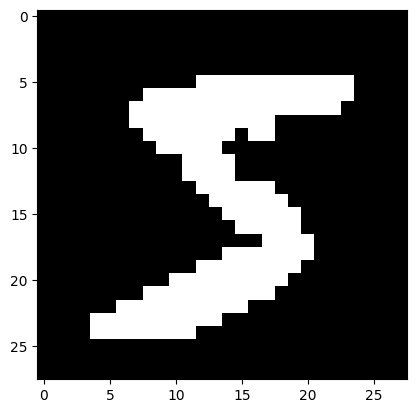

In [5]:
#binarize
def binarize(data):
  b_data = np.where(data >= 0.5, 1, 0)
  return b_data
b_tx = binarize(tr_X)
#print(b_data[0], b_data.shape)
plt.imshow(b_tx[0], cmap="gray")
print(b_tx.shape)

In [6]:
from numpy.ma.core import divide
#classify into dictionary based on y (label)
def classify(x, y):
  dic = {}
  for i in range(10):
    x = binarize(x.reshape(x.shape[0], 784))
    dic[i] = x[y == i]
    #print(dic[i].shape)
  return dic

tr_dic, vali_dic, t_dic, combo_dic = classify(tr_X, tr_y), classify(vali_X, vali_y), classify(t_X, t_y), classify(combo_X, combo_y)

In [7]:
def reshape(x):
  return x.reshape(x.shape[0], 784)

## Bayes rule with Bernoulli mixtures

In [52]:
def EM_algo(data, M): 
  #initiate, input must be binary
  data = binarize(data)
  n_mean = np.mean(data, axis=0)
  d, N = data[0].size, data[:, 0].size

  arr = np.random.rand(N, M)
  row_sums = arr.sum(axis=1)
  W = arr*(10**2) / row_sums.reshape((-1, 1))
  lik = 0
  #iteration
  for i in range(1000):
    pi, P = W.mean(axis=0), (data.T @ W + 1) / (W.sum(axis=0) + 2) 
    f = np.dot(data, np.log(P)) + np.dot(1 - data, np.log(1 - P)) + np.log(pi)
    W = np.exp(f - np.max(f, axis=1, keepdims=True))
    W = (W+0.0001) / (W.sum(axis=1,keepdims=True) + 0.0001) #prevent from dividing by 0

    new_lik = np.sum(np.log(W @ pi + 0.0001))
    #print(f"epoch {i}, newlikelihood = {new_lik}")
    if abs(lik - new_lik) < 0.001: #break/convergenc condition
      break #converge
    lik = new_lik
  return P, pi

In [8]:
# p, pi = EM_algo(b_tx, 10)
# fig, axs = plt.subplots(nrows=1, ncols=10, figsize=(15, 5))
# for i in range(10): #when M = 10
#   axs[i].imshow(p[:,i].reshape((28, 28)), cmap='gray')


# print(p.shape, pi.shape)
# tr_dic, vali_dic, t_dic = classify(tr_X), classify(vali_X), classify(t_X)
# return -> (784, 10) (10,)

# code to test around shape of EM wrapper
# product = b_tx @ np.log(p) + (1-b_tx) @ np.log(1-p)
# print(b_tx.shape, np.log(p).shape, (b_tx @ np.log(p)).shape, product.shape, pi.shape)
# print(product[:1])
# f = np.exp(product) @ pi
# print(f.shape) 

In [75]:
def EM_wrapper(tr_dic, vali_X, vali_y): #wrapper fxn
  err_rate = []
  for M in [1, 5, 10, 20]:
    print(f"========= test mixture model with M = {M} =========")
    f_dic = {}
    for y in range(10):
      p, pi = EM_algo(tr_dic[y], M)
      product = vali_X @ np.log(p) + (1-vali_X) @ np.log(1-p) #ixc + paim, compute maximum of every row
      #f2 = np.exp(product*0.001) @ pi #number_of_data:1, choose the biggest one among all y as the right label
      f = logsumexp((product*0.001 + np.log(pi)), axis=1)
      #print(f[0], f2[0], pi, np.log(pi))
      f_dic[y] = f
      #print(f)
      #print(f"the first dp with label {y} has result {f[1]}")
    #calculate error rate
    predict_label = []
    for i in range(vali_y.size):
      max_p, max_l = float('-inf'), float('-inf')
      for y2 in range(10):
        if f_dic[y2][i] > max_p:
          max_p, max_l = f_dic[y2][i], y2
      predict_label.append(max_l)
    err = np.count_nonzero(predict_label != vali_y)
    print(f"error rate for M = {M} is {err/vali_y.size}")
    err_rate.append(err)


In [76]:
EM_wrapper(tr_dic, vali_X.reshape(vali_X.shape[0], 784), vali_y)

========= test mixture model with M = 1 =========
error rate for M = 1 is 0.27014285714285713
========= test mixture model with M = 5 =========
error rate for M = 5 is 0.2005
========= test mixture model with M = 10 =========
error rate for M = 10 is 0.18978571428571428
========= test mixture model with M = 20 =========
error rate for M = 20 is 0.19235714285714287


According to the test result above, I decide to choose M = 10 (which gives back the lowest error rate)

In [79]:
def EM_wrapper_t(tr_dic, vali_X, vali_y, M): #wrapper fxn
  print(f"========= test mixture model with M = {M} =========")
  f_dic = {}
  for y in range(10):
    p, pi = EM_algo(tr_dic[y], M)
    product = vali_X @ np.log(p) + (1-vali_X) @ np.log(1-p) #ixc + paim, compute maximum of every row
    #f2 = np.exp(product*0.001) @ pi #number_of_data:1, choose the biggest one among all y as the right label
    f = logsumexp((product*0.001 + np.log(pi)), axis=1)
    #print(f[0], f2[0], pi, np.log(pi))
    f_dic[y] = f
    #print(f)
    #print(f"the first dp with label {y} has result {f[1]}")
  #calculate error rate
  predict_label = []
  for i in range(vali_y.size):
    max_p, max_l = float('-inf'), float('-inf')
    for y2 in range(10):
      if f_dic[y2][i] > max_p:
        max_p, max_l = f_dic[y2][i], y2
    predict_label.append(max_l)
  err = np.count_nonzero(predict_label != vali_y)
  print(f"error rate for M = {M} is {err/vali_y.size}")


In [82]:
print(combo_dic[0].shape, t_X.shape, t_y.shape)

(5531, 784) (14000, 28, 28) (14000,)


In [85]:
EM_wrapper_t(combo_dic, reshape(t_X), t_y, 10)

========= test mixture model with M = 10 =========
error rate for M = 10 is 0.20257142857142857


## Logistic regression

### raw data

In [11]:
for C in [1e-8, 1e-5, 1e-2, 1, 100, 1e5]:
  lr = LogisticRegression(fit_intercept=True, C=C, penalty="l2", multi_class="multinomial", solver="lbfgs")
  lr.fit(tr_X.reshape(tr_X.shape[0], 784), tr_y)
  lr_r_label = lr.predict(vali_X.reshape(vali_X.shape[0], 784))
  lr_r_err = np.count_nonzero(lr_r_label != vali_y)
  print(f"for C = {C}, error rate is {lr_r_err/vali_y.size}")

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


for C = 1e-08, error rate is 0.11371428571428571


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


for C = 1e-05, error rate is 0.07121428571428572


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


for C = 0.01, error rate is 0.0715


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


for C = 1, error rate is 0.07107142857142858


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


for C = 100, error rate is 0.07178571428571429
for C = 100000.0, error rate is 0.07185714285714286


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


I pick C = 100 with error rate of 0.07142857 (all the errors are almost the same)

In [12]:
#test
lr = LogisticRegression(fit_intercept=True, C=100, penalty="l2", multi_class="multinomial", solver="lbfgs")
lr.fit(combo_X.reshape(combo_X.shape[0], 784), combo_y)
lr_r_label = lr.predict(t_X.reshape(t_y.shape[0], 784))
lr_r_err = np.count_nonzero(lr_r_label != t_y)
print(f"for C = {100}, final error rate is {lr_r_err/vali_y.size}")

for C = 1e-05, final error rate is 0.07942857142857143


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### PCA

In [8]:
def my_PCA(sliced_arr, num):
  sliced_arr = sliced_arr.reshape(sliced_arr.shape[0], 784)
  features = sliced_arr.T
  cov_matrix = np.cov(features)
  #cov_matrix[:5]
  values, vectors = np.linalg.eig(cov_matrix)
  #values[:5]
  projected_1 = sliced_arr.dot(vectors.T[0])
  projected_2 = sliced_arr.dot(vectors.T[1])

  ret = []
  for i in range(num):
    ret.append(sliced_arr.dot(vectors.T[i]))
  ret = np.array(ret)
  return np.real(ret.T)

In [19]:
from sklearn.decomposition import PCA
from sklearn.exceptions import ConvergenceWarning
import warnings
from sklearn.metrics import accuracy_score

def PCA_traverse(tr_X, tr_y, vali_X, vali_y): #this is function to find optimal C and PCA
  acc = []
  tr_X, vali_X = reshape(tr_X), reshape(vali_X)
  with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    x_train_tilde = tr_X - tr_X.mean(axis=0)
    x_val_tilde = vali_X - vali_X.mean(axis=0)
    U, S, Vt = np.linalg.svd(x_train_tilde, full_matrices=False)
    for dim in [1, 50, 784]:
      Vtm = Vt[:dim]
      train_proj = x_train_tilde @ Vtm.T
      val_proj = x_val_tilde @ Vtm.T
      #PCA_tr_X, PCA_vali_X, = my_PCA(tr_X, dim), my_PCA(vali_X, dim)
      for C in [1e-2, 100, 1e5]:
        lr = LogisticRegression(fit_intercept=True, C=C, penalty="l2", multi_class="multinomial", solver="lbfgs")
        lr.fit(train_proj, tr_y)
        lr_r_label = lr.predict(val_proj)
        #lr_r_err = np.count_nonzero(lr_r_label != vali_y)
        acc.append(accuracy_score(lr_r_label, vali_y))
    i = 0
    for dim in [1, 50, 784]:
      for C in [1e-2, 100, 1e5]:
        print(f"for PCA dim of {dim} and C = {C}, final accuracy rate is {acc[i]}")
        i += 1

In [20]:
PCA_traverse(tr_X, tr_y, vali_X, vali_y)

for PCA dim of 1 and C = 0.01, final accuracy rate is 0.30642857142857144
for PCA dim of 1 and C = 100, final accuracy rate is 0.3072142857142857
for PCA dim of 1 and C = 100000.0, final accuracy rate is 0.3072142857142857
for PCA dim of 50 and C = 0.01, final accuracy rate is 0.9055
for PCA dim of 50 and C = 100, final accuracy rate is 0.9057142857142857
for PCA dim of 50 and C = 100000.0, final accuracy rate is 0.9057142857142857
for PCA dim of 784 and C = 0.01, final accuracy rate is 0.9285714285714286
for PCA dim of 784 and C = 100, final accuracy rate is 0.9288571428571428
for PCA dim of 784 and C = 100000.0, final accuracy rate is 0.9288571428571428


According to the test, with higher dimension of PCA and C there comes lower error rate, thus I choose PCA dim = 50 (cannot pick 784 cause they'll be the same as raw data) and C = 100 because there's no much difference between c = 1e5 or 100. 
With higher dimension allowed in PCA, the accuracy also increase, meaning that the feature of data is captured better. when dim = 1, the accuracy is really low, meaning that more feature are required to represent the image

In [24]:
C, dim = 100, 50
combo_X, t_X = reshape(combo_X), reshape(t_X)
x_train_tilde = combo_X - combo_X.mean(axis=0)
x_val_tilde = t_X - t_X.mean(axis=0)
U, S, Vt = np.linalg.svd(x_train_tilde, full_matrices=False)
Vtm = Vt[:dim]
train_proj = x_train_tilde @ Vtm.T
val_proj = x_val_tilde @ Vtm.T

#PCA_tr_X, PCA_vali_X, = my_PCA(tr_X, dim), my_PCA(vali_X, dim)
lr = LogisticRegression(fit_intercept=True, C=C, penalty="l2", multi_class="multinomial", solver="lbfgs")
lr.fit(x_train_tilde, combo_y)
lr_r_label = lr.predict(x_val_tilde)
print(f"for PCA dim of {dim} and C = {C}, final accuracy is {accuracy_score(lr_r_label, t_y)}")


for PCA dim of 50 and C = 100, final accuracy is 0.9132857142857143


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Both raw data and PCA hav lower error rate than Bayes rule with Bernoulli mixture

## Stochastic gradient descent

In [72]:
#test with label binarizer
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()
y_oh = LabelBinarizer().fit_transform(tr_y)
print(y_oh.shape)

(42000, 10)


In [151]:
from scipy.special import softmax
from scipy.special import logsumexp
from sklearn.preprocessing import LabelBinarizer

def neg_likelihood(X, y, W):#loss
  Z = - X @ W
  return (1/X.shape[0]) * (np.trace(X @ W @ y.T) + np.sum(logsumexp(Z, axis=1)))
  

def gradient(X, y, W, reg):
  P = softmax(-X @ W, axis=1) #likelihood
  #print(X.T.shape, y.shape, P.shape, W.shape)
  N = X.shape[0]
  gradient = (1/N)*(X.T @ (y-P)) + 2*reg*W
  return gradient

def SGD(data, Y, learning_rate, step, reg):
  data = data.reshape(data.shape[0], 784)
  y = LabelBinarizer().fit_transform(Y)
  W = np.zeros((data.shape[1], y.shape[1])) #theta
  L = 0
  print("start training...")
  for i in range(step):
    #print(f"========= Epoch {i} =========")
    batch_idx = np.random.choice(data.shape[0], size=500, replace=False) #I choose batch size = 50
    batch_X, batch_y = data[batch_idx], y[batch_idx]
    W -= learning_rate*gradient(batch_X, batch_y, W, reg)
    new_L = neg_likelihood(batch_X, batch_y, W)
    if i%200 == 0:
      print(f"epoch {i}, now loss is {new_L}")
    if abs(L - new_L) < 1e-7:
      print("converge")
      break #converge
    L = new_L 
  return W

def err_rate(W, X, y):
  X = X.reshape(X.shape[0], 784)
  P = softmax((-X @ W) , axis=1)
  rate = np.count_nonzero(np.argmax(P, axis=1) != y)/X.shape[0]
  return rate

In [166]:
learning, step = 0.1, 1000
for l in [0, 1e-7, 1e-5, 0.001, 0.1]: #I normalize the data below, so accompanying it with smaller lambda
  print(f"========= C {l} =========")
  W = SGD(tr_X/100, tr_y, learning, step, l)
  err = err_rate(W, vali_X/100, vali_y) 

  print(f"for C = {l}, error rate is {err}")

========= C 0 =========
start training...
epoch 0, now loss is 1.720052169473933
epoch 200, now loss is 0.35682354087625573
epoch 400, now loss is 0.2403704713108855
epoch 600, now loss is 0.26368788449566183
epoch 800, now loss is 0.22497972505924918
for C = 0, error rate is 0.08214285714285714
========= C 1e-07 =========
start training...
epoch 0, now loss is 1.6533538958594163
epoch 200, now loss is 0.3784568591899006
epoch 400, now loss is 0.2998280121147609
epoch 600, now loss is 0.2878431420253073
epoch 800, now loss is 0.28107623888353556
for C = 1e-07, error rate is 0.08021428571428571
========= C 1e-05 =========
start training...
epoch 0, now loss is 1.6752658059929904
epoch 200, now loss is 0.3497755057339655
epoch 400, now loss is 0.2860141035436145
epoch 600, now loss is 0.3241454667158814
epoch 800, now loss is 0.28274412877913074
for C = 1e-05, error rate is 0.07978571428571428
========= C 0.001 =========
start training...
epoch 0, now loss is 1.7408909930818348
epoch 200

test with different regularization factor $\lambda$, I pick C = $1/\lambda$ = 1e-05 (error rate) (there're no much big diffrernt between different reg factor though)

In [167]:
#test data
W_t = SGD(combo_X/100, combo_y, learning, step, 1e-5)
err = err_rate(W, t_X/100, t_y) 
print(f"final error rate is {err}")



start training...
epoch 0, now loss is 1.6844762875393127
epoch 200, now loss is 0.346113688361821
epoch 400, now loss is 0.30455367835248764
epoch 600, now loss is 0.2838441133299548
epoch 800, now loss is 0.2286968853359922
final error rate is 0.13064285714285714


observation: SGD result has slightly larger error rate than simple logistic regression for both raw data, smaller error rate comparing to PCA projection with low dimension